# Evaluating Mode Collapse and Mode Dropping using Diversipy

**Mode collapse** and **mode dropping** are two commonly faced problems in evaluating generative models related to a decrease in output diversity as compared to the input/training data. 

- **Mode dropping** occurs when a model fails to capture all parts of an input distribution. Specifically, a model that suffers from this problem "drops" a category or distinct cluster of data ("mode") in its output, so that modes are underrepresented in the generated outputs. For example, we would consider a model trained to generate images of animals that never outputs a image of a bird to suffer from mode dropping.

- **Mode collapse** describes the lack of diversity within modes. For example, a model trained to on a wide variety of dog pictures suffers from mode collapse if it only ever outputs images of almost identical-looking dogs failing to capture the full diversity of this image class.  

Both mode collapse and mode dropping can be detected using `Diversipy` by computing MagDiff between the output data and the input data (reference dataset). Higher MagDiffs measuring larger differences in diversity indicate greater likelihood of mode dropping and/or collapse. By evaluating differences in diversity across multiple scales, MagDiff is shown to detect mode dropping and collapse earlier than existing generative model evaluation metrics.

We include the following demo to show how `Diversipy` can be used to evaluate mode dropping and collapse for generative model evaluation.

## Importing Packages and Datasets

In [1]:
# Import statements
from matplotlib.animation import FuncAnimation
from magnipy.magnipy import Magnipy
from magnipy.diversipy import Diversipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tutorial_data import *

We begin by creating our toy dataset by sampling from three Gaussians to create **three distinct modes** (clusters).

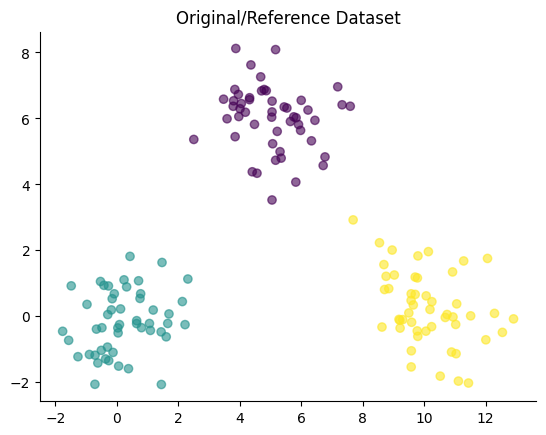

In [8]:
# Setting hyperparameters
np.random.seed(4)
mean1 = [5, 6]
cov1 = np.eye(2) * 1.1
size = 50

# Sampling data
points1 = sample_points_gaussian(mean1, cov1, size)
points2 = sample_points_gaussian([0, 0], cov1, size)
points3 = sample_points_gaussian([10, 0], cov1, size)
initial_dataset = np.concatenate([points1, points2, points3], axis=0)
x = initial_dataset[:, 0]
y = initial_dataset[:, 1]
more_points1 = sample_points_gaussian(mean1, cov1, size * 2)

# Plotting
colors = np.array(np.concatenate([np.zeros(size), np.ones(size), np.ones(size) * 2]))
plt.scatter(x, y, c=colors, alpha=0.6)
plt.title("Original/Reference Dataset")
sns.despine()

## Simulating Mode Dropping

Next, **we simulate mode dropping** by iteratively removing 1 point from each of the 'green' and 'yellow' modes and adding two new points sampled from same Gaussian that made the purple mode. This effectively replaces two points from other modes with two points in the purple mode, i.e. "dropping" the green and yellow modes.

As you would expect, as more points are replaced (i.e. more mode dropping occurs), the diversity of the perturbed dataset declines. We will show this rigorously later.

In [4]:
# Get datasets that simulate gradual mode dropping

# Replacement points in purple mode
more_points1 = sample_points_gaussian(mean1, cov1, size * 2)

Xs = []
colors = []
for frame in range(size):
    # Replacing points from modes 2 and 3 with points from mode 1 Gaussian
    X_new = np.concatenate(
        [
            points1,
            points2[: (size - frame)],
            points3[: (size - frame)],
            more_points1[: (2 * (frame))],
        ],
    )
    # Updating color mapping
    new_colors = np.array(
        np.concatenate(
            [
                np.zeros(size),
                np.ones(size - frame),
                np.ones(size - frame) * 2,
                np.zeros(2 * (frame)),
            ]
        )
    )
    # Adding to ongoing simulation data
    Xs.append(X_new)
    colors.append(new_colors)

print(f"Xs is a list of {len(Xs)} datasets (each with {len(Xs[0])} points) that simulates gradual mode dropping.")
print(f"and colors is a list of {len(colors)} corresponding colormaps.")

Xs is a list of 50 datasets (each with 150 points) that simulates gradual mode dropping.
colors is a list of 50 corresponding colormaps.


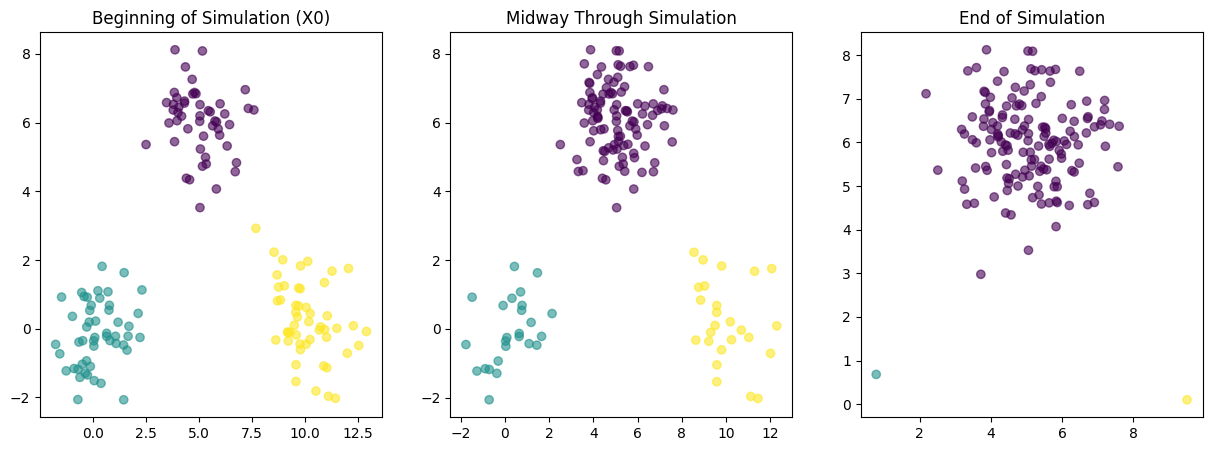

In [5]:
# Plotting visual summary of mode dropping simulation
plot_simulation_progression(Xs, colors, size)


## MagDiff Reliably Detects Mode Dropping

At each iteration of this replacement process detailed above, we compute the following with Diversipy:

1. The intrinsic diversity **(MagArea)** of the latest interation of our replacement dataset (**declines** with mode dropping).
2. The **(MagDiff)** between our original dataset and the latest iteration of our replacement dataset (which **increases** with mode dropping).
3. The **__normalised__ MagDiff**, which tracks the MagDiff divided by the MagArea of the reference dataset (which also **increases** with mode dropping).

Let's do this all at once, before diving into each metric individually.

In [11]:
# Intializing Diversipy object with our simulated datasets, such that X0 is our reference space (idx=0)
div = Diversipy(Xs=Xs, ref_space=0)

# Calculating intrinsic diversity (MagArea) for all datasets
mag_areas = div.MagAreas(scale=True)
# Calculating difference in diversity with respect to X0 (MagDiff) for all datasets
mag_diffs = div.MagDiffs(scale=True, pairwise=False)
# Calculating normalised MagDiff for all datasets
mag_diffs_normalised = mag_diffs / mag_areas[0]

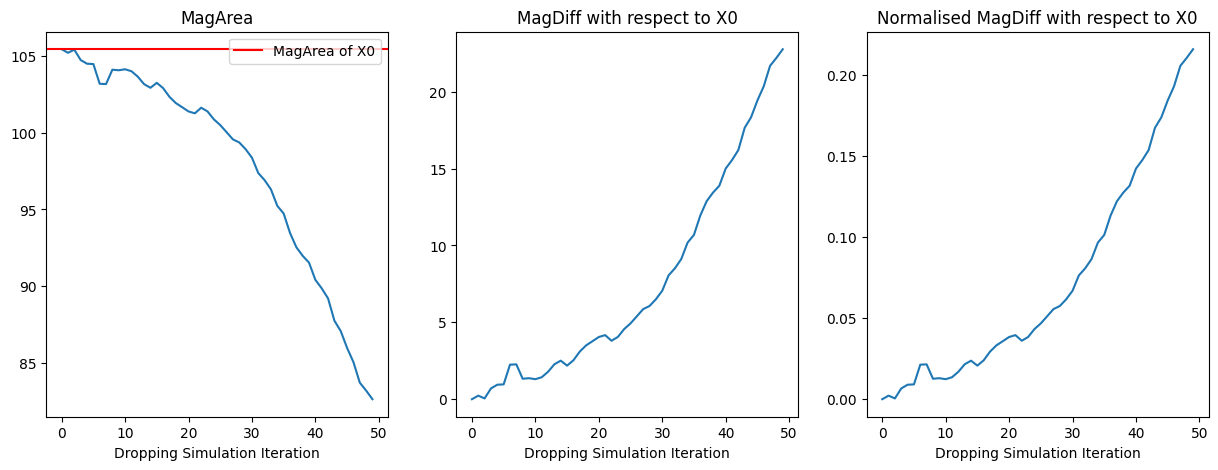

In [12]:
# Plotting
plot_diversity_measures(mag_areas, mag_diffs, mag_diffs_normalised, size)

## MagArea

Recall that **MagArea** measures the intrinsic diversity of a dataset by integrating over the magnitude function of a dataset. As mode dropping occurs and the diversity of the datasets decline, we see MagArea decline as well. This in it of itself is notable.

However, we are more interested in how the diversity of these datasets **compare** to our original dataset. For this, **MagDiff** is a better metric.

![Mode Dropping Simulation (MagArea)](assets/mode_dropping/magarea.gif)

## MagDiff

Recall that **MagDiff** is the difference in the diversity of the original dataset (a constant) and the replacement dataset (steadily decreasing), and thus grows over time. Thus, **MagDiff** gives us a sense of how much diversity has been gained/lost with respect to our original dataset.

Recall the formal definition of **MagDiff**:

Let $t_{ref}$ be the convergence scale of the reference space $X_{\text{ref}}$ and $X_{p}$ is the perturbed data. Then we compute: $$\text{MagDiff} = \frac{1}{t_{\text{ref}}} \int_{0}^{t_{\text{ref}}} \text{Mag}_{X_{p}}(t) - \text{Mag}_{X_{\text{ref}}}(t) \text{dt}$$ We have that this difference can be negative if the diversity of $X_{\text{ref}}$ is higher than of $X_{p}$. Also, note that we choose to scale the integral by the convergence scale of the reference $t_{ref}$ to remove the impact of the scale of $t$ on the final result.

![Mode Dropping Simulation (MagDiff)](assets/mode_dropping/magdiff.gif)

## Normalised MagDiff

We can also visualize this process with the **normalised MagDiff**, that is, the MagDiff between the original dataset and the replacement dataset divided by the MagArea of the original dataset. This is especially helpful if we are tracking and comparing mode dropping across different original datasets.

With respect to MagDiff, normalising simply changes the scale of the y-axis by  plotting the difference in diversity relative to the diversity of the reference.
$$\text{MagDiff} = \frac{1}{\text{MagArea}(X_{\text{ref}})} \int_{0}^{t_{\text{ref}}} \text{Mag}_{X_{p}}(t) - \text{Mag}_{X_{\text{ref}}}(t) \text{dt}$$

![Mode Dropping Simulation (Normalised MagDiff)](assets/mode_dropping/normalised.gif)

## Extended Results for Evaluating Graph Generative Models

MagDiff can thus be a helpful tool for detecting mode dropping and mode collapse in ML. In fact, the normalized MagDiff (in the demo directly above) even outperforms other commonly used detection techniques.

![Comparison with Other was](..//assets/mode_dropping/mode_collapse_comparison.png)

Figure from [Metric Space Magnitude for Evaluating the Diversity of Latent Representations](https://arxiv.org/abs/2311.16054). See also for further discussion.